## Child Mind Institute

---

### Import Packages

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import torch
import os

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import KFold
from copy import deepcopy
from tqdm import tqdm

### Notebook Constants

In [2]:
SEED = 42
random.seed(SEED)
_ = torch.manual_seed(SEED)
DEVICE = (
    torch.device("cuda")
    if torch.cuda.is_available()
    else (
        torch.device("mps")
        if torch.backends.mps.is_available()
        else torch.device("cpu")
    )
)
DATASET_FOLDER = "dataset"
TARGET = "sii"

### Load Static Data

In [3]:
train_data = pd.read_csv(os.path.join(DATASET_FOLDER, "train.csv"))
test_data = pd.read_csv(os.path.join(DATASET_FOLDER, "test.csv"))

### Clean Static Data

In [4]:
train_data = train_data.drop(columns=[f"PCIAT-PCIAT_{i + 1:02d}" for i in range(20)])
train_data = train_data.drop(columns=["PCIAT-PCIAT_Total", "PCIAT-Season"])
train_data = train_data.drop(columns=["SDS-SDS_Total_T"])
train_data = train_data.drop(columns=["Physical-Waist_Circumference"])
train_data = train_data.drop(
    columns=[
        "BIA-BIA_BMI",
        "BIA-BIA_BMC",
        "BIA-BIA_BMR",
        "BIA-BIA_DEE",
        "BIA-BIA_ECW",
        "BIA-BIA_FFM",
        "BIA-BIA_ICW",
        "BIA-BIA_LDM",
        "BIA-BIA_LST",
        "BIA-BIA_SMM",
        "BIA-BIA_TBW",
        "BIA-BIA_FMI",
    ]
)
train_data = train_data.drop(
    columns=["FGC-FGC_SRR", "FGC-FGC_SRR_Zone", "FGC-FGC_GSND", "FGC-FGC_GSND_Zone"]
)
train_data = train_data.drop([3147, 3205, 3511]) # outliers for BIA-BIA_Fat
train_data.loc[train_data["Physical-BMI"] == 0.0, "Physical-BMI"] = np.nan
train_data.loc[train_data["CGAS-CGAS_Score"] > 100, "CGAS-CGAS_Score"] = 99.0
train_data.loc[train_data["FGC-FGC_CU_Zone"].notna(), "FGC-FGC_CU_Zone"] += 1
train_data.loc[train_data["FGC-FGC_PU_Zone"].notna(), "FGC-FGC_PU_Zone"] += 1
train_data.loc[train_data["FGC-FGC_SRL_Zone"].notna(), "FGC-FGC_SRL_Zone"] += 1
train_data.loc[train_data["FGC-FGC_TL_Zone"].notna(), "FGC-FGC_TL_Zone"] += 1

In [5]:
test_data = test_data.drop(columns=["SDS-SDS_Total_T"])
test_data = test_data.drop(columns=["Physical-Waist_Circumference"])
test_data = test_data.drop(
    columns=[
        "BIA-BIA_BMI",
        "BIA-BIA_BMC",
        "BIA-BIA_BMR",
        "BIA-BIA_DEE",
        "BIA-BIA_ECW",
        "BIA-BIA_FFM",
        "BIA-BIA_ICW",
        "BIA-BIA_LDM",
        "BIA-BIA_LST",
        "BIA-BIA_SMM",
        "BIA-BIA_TBW",
        "BIA-BIA_FMI",
    ]
)
test_data = test_data.drop(
    columns=["FGC-FGC_SRR", "FGC-FGC_SRR_Zone", "FGC-FGC_GSND", "FGC-FGC_GSND_Zone"]
)
test_data.loc[test_data["Physical-BMI"] == 0.0, "Physical-BMI"] = np.nan
test_data.loc[test_data["CGAS-CGAS_Score"] > 100, "CGAS-CGAS_Score"] = 99.0
test_data.loc[test_data["FGC-FGC_CU_Zone"].notna(), "FGC-FGC_CU_Zone"] += 1
test_data.loc[test_data["FGC-FGC_PU_Zone"].notna(), "FGC-FGC_PU_Zone"] += 1
test_data.loc[test_data["FGC-FGC_SRL_Zone"].notna(), "FGC-FGC_SRL_Zone"] += 1
test_data.loc[test_data["FGC-FGC_TL_Zone"].notna(), "FGC-FGC_TL_Zone"] += 1

In [6]:
def trivial_imputation(train_ref, test_ref, category, skip_test=False):
    mask = train_ref[f"{category}Season"].isna()
    train_ref.loc[mask, f"{category}Season"] = "Not Taken"
    for idx in train_ref[mask].index:
        for col in train_ref.columns:
            if col.startswith(category) and "Season" not in col:
                train_ref.loc[idx, col] = 0.0
    if not skip_test:
        mask = test_ref[f"{category}Season"].isna()
        test_ref.loc[mask, f"{category}Season"] = "Not Taken"
        for idx in test_ref[mask].index:
            for col in test_ref.columns:
                if col.startswith(category) and "Season" not in col:
                    test_ref.loc[idx, col] = 0.0
    return train_ref, test_ref

In [7]:
def cleanup_PAQ_fields(train_ref, test_ref):
    train_ref["PAQ_Total"] = np.where(
        train_ref["PAQ_C-PAQ_C_Total"].notna(),
        train_ref["PAQ_C-PAQ_C_Total"],
        np.where(
            train_ref["PAQ_A-PAQ_A_Total"].notna(),
            train_ref["PAQ_A-PAQ_A_Total"],
            0.0
        ),
    )
    train_ref["PAQ_Season"] = np.where(
        train_ref["PAQ_C-Season"].notna(),
        train_ref["PAQ_C-Season"],
        np.where(
            train_ref["PAQ_A-Season"].notna(),
            train_ref["PAQ_A-Season"],
            "Not Taken"
        ),
    )
    train_ref = train_ref.drop(columns=["PAQ_C-PAQ_C_Total", "PAQ_A-PAQ_A_Total", "PAQ_C-Season", "PAQ_A-Season"])
    test_ref["PAQ_Total"] = np.where(
        test_ref["PAQ_C-PAQ_C_Total"].notna(),
        test_ref["PAQ_C-PAQ_C_Total"],
        np.where(
            test_ref["PAQ_A-PAQ_A_Total"].notna(),
            test_ref["PAQ_A-PAQ_A_Total"],
            0.0
        ),
    )
    test_ref["PAQ_Season"] = np.where(
        test_ref["PAQ_C-Season"].notna(),
        test_ref["PAQ_C-Season"],
        np.where(
            test_ref["PAQ_A-Season"].notna(),
            test_ref["PAQ_A-Season"],
            "Not Taken"
        ),
    )
    test_ref = test_ref.drop(columns=["PAQ_C-PAQ_C_Total", "PAQ_A-PAQ_A_Total", "PAQ_C-Season", "PAQ_A-Season"])
    return train_ref, test_ref

In [8]:
def imputation_age_and_sex(train_ref, test_ref, col, strategy):
    train_ref["age_group"] = pd.cut(train_ref["Basic_Demos-Age"], bins=[4, 7, 10, 13, 16, 19, 22], labels=["<=7", "8-10", "11-13", "14-16", "17-19", ">=20"])
    test_ref["age_group"] = pd.cut(test_ref["Basic_Demos-Age"], bins=[4, 7, 10, 13, 16, 19, 22], labels=["<=7", "8-10", "11-13", "14-16", "17-19", ">=20"])
    subclass_means = train_ref.groupby(by=["Basic_Demos-Sex", "age_group"], observed=False)[col].agg(strategy)
    groups = train_ref[["Basic_Demos-Sex", "age_group"]]
    mask = train_ref[col].isna()
    for idx in train_ref[mask].index:
        sex, age = tuple(groups.loc[idx])
        try:
            subclass_mean = subclass_means[(sex, age)]
            train_ref.loc[idx, col] = subclass_mean if subclass_mean == subclass_mean else subclass_means[(1 - sex, age)]
        except:
            continue
    groups = test_ref[["Basic_Demos-Sex", "age_group"]]
    mask = test_ref[col].isna()
    for idx in test_ref[mask].index:
        sex, age = tuple(groups.loc[idx])
        try:
            subclass_mean = subclass_means[(sex, age)]
            test_ref.loc[idx, col] = subclass_mean if subclass_mean == subclass_mean else subclass_means[(1 - sex, age)]
        except:
            continue
    train_ref = train_ref.drop(columns=["age_group"])
    test_ref = test_ref.drop(columns=["age_group"])
    return train_ref, test_ref

In [9]:
def imputation_age_and_sex_and_custom(train_ref, test_ref, custom_col, col, strategy):
    train_ref["age_group"] = pd.cut(train_ref["Basic_Demos-Age"], bins=[4, 7, 10, 13, 16, 19, 22], labels=["<=7", "8-10", "11-13", "14-16", "17-19", ">=20"])
    test_ref["age_group"] = pd.cut(test_ref["Basic_Demos-Age"], bins=[4, 7, 10, 13, 16, 19, 22], labels=["<=7", "8-10", "11-13", "14-16", "17-19", ">=20"])
    subclass_means = train_ref.groupby(by=["Basic_Demos-Sex", "age_group", custom_col], observed=False)[col].agg(strategy)
    groups = train_ref[["Basic_Demos-Sex", "age_group", custom_col]]
    mask = train_ref[col].isna()
    for idx in train_ref[mask].index:
        sex, age, custom = tuple(groups.loc[idx])
        try:
            subclass_mean = subclass_means[(sex, age, custom)]
            train_ref.loc[idx, col] = subclass_mean if subclass_mean == subclass_mean else subclass_means[(1 - sex, age, custom)]
        except:
            continue
    groups = test_ref[["Basic_Demos-Sex", "age_group", custom_col]]
    mask = test_ref[col].isna()
    for idx in test_ref[mask].index:
        sex, age, custom = tuple(groups.loc[idx])
        try:
            subclass_mean = subclass_means[(sex, age, custom)]
            test_ref.loc[idx, col] = subclass_mean if subclass_mean == subclass_mean else subclass_means[(1 - sex, age, custom)]
        except:
            continue
    subclass_means = train_ref.groupby(by=["Basic_Demos-Sex", "age_group"], observed=False)[col].agg(strategy)
    groups = train_ref[["Basic_Demos-Sex", "age_group"]]
    mask = train_ref[col].isna()
    for idx in train_ref[mask].index:
        sex, age = tuple(groups.loc[idx])
        try:
            subclass_mean = subclass_means[(sex, age)]
            train_ref.loc[idx, col] = subclass_mean if subclass_mean == subclass_mean else subclass_means[(1 - sex, age)]
        except:
            continue
    groups = test_ref[["Basic_Demos-Sex", "age_group"]]
    mask = test_ref[col].isna()
    for idx in test_ref[mask].index:
        sex, age = tuple(groups.loc[idx])
        try:
            subclass_mean = subclass_means[(sex, age)]
            test_ref.loc[idx, col] = subclass_mean if subclass_mean == subclass_mean else subclass_means[(1 - sex, age)]
        except:
            continue
    train_ref = train_ref.drop(columns=["age_group"])
    test_ref = test_ref.drop(columns=["age_group"])
    return train_ref, test_ref

In [10]:
def imputation_age_and_sex_and_bmi(train_ref, test_ref, col, strategy):
    train_ref["BMI_group"] = pd.cut(train_ref["Physical-BMI"], bins=[0, 18.5, 25, 30, 35, 100], labels=["Underweight", "Normal", "Overweight", "Obese", "Severely Obese"])
    train_ref["age_group"] = pd.cut(train_ref["Basic_Demos-Age"], bins=[4, 7, 10, 13, 16, 19, 22], labels=["<=7", "8-10", "11-13", "14-16", "17-19", ">=20"])
    test_ref["BMI_group"] = pd.cut(test_ref["Physical-BMI"], bins=[0, 18.5, 25, 30, 35, 100], labels=["Underweight", "Normal", "Overweight", "Obese", "Severely Obese"])
    test_ref["age_group"] = pd.cut(test_ref["Basic_Demos-Age"], bins=[4, 7, 10, 13, 16, 19, 22], labels=["<=7", "8-10", "11-13", "14-16", "17-19", ">=20"])
    subclass_means = train_ref.groupby(by=["Basic_Demos-Sex", "age_group", "BMI_group"], observed=False)[col].agg(strategy)
    groups = train_ref[["Basic_Demos-Sex", "age_group", "BMI_group"]]
    mask = train_ref[col].isna()
    for idx in train_ref[mask].index:
        sex, age, bmi = tuple(groups.loc[idx])
        try:
            subclass_mean = subclass_means[(sex, age, bmi)]
            train_ref.loc[idx, col] = subclass_mean if subclass_mean == subclass_mean else subclass_means[(1 - sex, age, bmi)]
        except:
            continue
    groups = test_ref[["Basic_Demos-Sex", "age_group", "BMI_group"]]
    mask = test_ref[col].isna()
    for idx in test_ref[mask].index:
        sex, age, bmi = tuple(groups.loc[idx])
        try:
            subclass_mean = subclass_means[(sex, age, bmi)]
            test_ref.loc[idx, col] = subclass_mean if subclass_mean == subclass_mean else subclass_means[(1 - sex, age, bmi)]
        except:
            continue
    subclass_means = train_ref.groupby(by=["Basic_Demos-Sex", "age_group"], observed=False)[col].agg(strategy)
    groups = train_ref[["Basic_Demos-Sex", "age_group"]]
    mask = train_ref[col].isna()
    for idx in train_ref[mask].index:
        sex, age = tuple(groups.loc[idx])
        try:
            subclass_mean = subclass_means[(sex, age)]
            train_ref.loc[idx, col] = subclass_mean if subclass_mean == subclass_mean else subclass_means[(1 - sex, age)]
        except:
            continue
    groups = test_ref[["Basic_Demos-Sex", "age_group"]]
    mask = test_ref[col].isna()
    for idx in test_ref[mask].index:
        sex, age = tuple(groups.loc[idx])
        try:
            subclass_mean = subclass_means[(sex, age)]
            test_ref.loc[idx, col] = subclass_mean if subclass_mean == subclass_mean else subclass_means[(1 - sex, age)]
        except:
            continue
    train_ref = train_ref.drop(columns=["age_group", "BMI_group"])
    test_ref = test_ref.drop(columns=["age_group", "BMI_group"])
    return train_ref, test_ref

In [11]:
def imputation_age_and_sex_and_bmi_and_custom(train_ref, test_ref, custom_col, col, strategy):
    train_ref["BMI_group"] = pd.cut(train_ref["Physical-BMI"], bins=[0, 18.5, 25, 30, 35, 100], labels=["Underweight", "Normal", "Overweight", "Obese", "Severely Obese"])
    train_ref["age_group"] = pd.cut(train_ref["Basic_Demos-Age"], bins=[4, 7, 10, 13, 16, 19, 22], labels=["<=7", "8-10", "11-13", "14-16", "17-19", ">=20"])
    test_ref["BMI_group"] = pd.cut(test_ref["Physical-BMI"], bins=[0, 18.5, 25, 30, 35, 100], labels=["Underweight", "Normal", "Overweight", "Obese", "Severely Obese"])
    test_ref["age_group"] = pd.cut(test_ref["Basic_Demos-Age"], bins=[4, 7, 10, 13, 16, 19, 22], labels=["<=7", "8-10", "11-13", "14-16", "17-19", ">=20"])
    subclass_means = train_ref.groupby(by=["Basic_Demos-Sex", "age_group", "BMI_group", custom_col], observed=False)[col].agg(strategy)
    groups = train_ref[["Basic_Demos-Sex", "age_group", "BMI_group", custom_col]]
    mask = train_ref[col].isna()
    for idx in train_ref[mask].index:
        sex, age, bmi, custom = tuple(groups.loc[idx])
        try:
            if custom == custom:
                subclass_mean = subclass_means[(sex, age, bmi, custom)]
                train_ref.loc[idx, col] = subclass_mean if subclass_mean == subclass_mean else subclass_means[(1 - sex, age, bmi, custom)]
        except:
            continue
    groups = test_ref[["Basic_Demos-Sex", "age_group", "BMI_group", custom_col]]
    mask = test_ref[col].isna()
    for idx in test_ref[mask].index:
        sex, age, bmi, custom = tuple(groups.loc[idx])
        try:
            if custom == custom:
                subclass_mean = subclass_means[(sex, age, bmi, custom)]
                test_ref.loc[idx, col] = subclass_mean if subclass_mean == subclass_mean else subclass_means[(1 - sex, age, bmi, custom)]
        except:
            continue
    subclass_means = train_ref.groupby(by=["Basic_Demos-Sex", "age_group", "BMI_group"], observed=False)[col].agg(strategy)
    groups = train_ref[["Basic_Demos-Sex", "age_group", "BMI_group"]]
    mask = train_ref[col].isna()
    for idx in train_ref[mask].index:
        sex, age, bmi = tuple(groups.loc[idx])
        try:
            subclass_mean = subclass_means[(sex, age, bmi)]
            train_ref.loc[idx, col] = subclass_mean if subclass_mean == subclass_mean else subclass_means[(1 - sex, age, bmi)]
        except:
            continue
    groups = test_ref[["Basic_Demos-Sex", "age_group", "BMI_group"]]
    mask = test_ref[col].isna()
    for idx in test_ref[mask].index:
        sex, age, bmi = tuple(groups.loc[idx])
        try:
            subclass_mean = subclass_means[(sex, age, bmi)]
            test_ref.loc[idx, col] = subclass_mean if subclass_mean == subclass_mean else subclass_means[(1 - sex, age, bmi)]
        except:
            continue
    subclass_means = train_ref.groupby(by=["Basic_Demos-Sex", "age_group"], observed=False)[col].agg(strategy)
    groups = train_ref[["Basic_Demos-Sex", "age_group"]]
    mask = train_ref[col].isna()
    for idx in train_ref[mask].index:
        sex, age = tuple(groups.loc[idx])
        try:
            subclass_mean = subclass_means[(sex, age)]
            train_ref.loc[idx, col] = subclass_mean if subclass_mean == subclass_mean else subclass_means[(1 - sex, age)]
        except:
            continue
    groups = test_ref[["Basic_Demos-Sex", "age_group"]]
    mask = test_ref[col].isna()
    for idx in test_ref[mask].index:
        sex, age = tuple(groups.loc[idx])
        try:
            subclass_mean = subclass_means[(sex, age)]
            test_ref.loc[idx, col] = subclass_mean if subclass_mean == subclass_mean else subclass_means[(1 - sex, age)]
        except:
            continue
    subclass_means = train_ref.groupby(by=["Basic_Demos-Sex"], observed=False)[col].agg(strategy)
    groups = train_ref["Basic_Demos-Sex"]
    mask = train_ref[col].isna()
    for idx in train_ref[mask].index:
        sex = groups.loc[idx]
        try:
            subclass_mean = subclass_means[sex]
            train_ref.loc[idx, col] = subclass_mean if subclass_mean == subclass_mean else subclass_means[1 - sex]
        except:
            continue
    groups = test_ref["Basic_Demos-Sex"]
    mask = test_ref[col].isna()
    for idx in test_ref[mask].index:
        sex = groups.loc[idx]
        try:
            subclass_mean = subclass_means[sex]
            test_ref.loc[idx, col] = subclass_mean if subclass_mean == subclass_mean else subclass_means[1 - sex]
        except:
            continue
    train_ref = train_ref.drop(columns=["age_group", "BMI_group"])
    test_ref = test_ref.drop(columns=["age_group", "BMI_group"])
    return train_ref, test_ref

In [12]:
train_data, test_data = trivial_imputation(train_data, test_data, "Physical-")
train_data, test_data = trivial_imputation(train_data, test_data, "Fitness_Endurance-")
train_data, test_data = trivial_imputation(train_data, test_data, "BIA-")
train_data, test_data = trivial_imputation(train_data, test_data, "SDS-")
train_data, test_data = trivial_imputation(train_data, test_data, "PreInt_EduHx-")
train_data, test_data = trivial_imputation(train_data, test_data, "CGAS-")
train_data, test_data = trivial_imputation(train_data, test_data, "FGC-")
train_data, test_data = cleanup_PAQ_fields(train_data, test_data)
train_data, test_data = imputation_age_and_sex(train_data, test_data, "Physical-BMI", "mean")
train_data, test_data = imputation_age_and_sex(train_data, test_data, "Physical-Height", "mean")
train_data, test_data = imputation_age_and_sex(train_data, test_data, "CGAS-CGAS_Score", "median")
train_data, test_data = imputation_age_and_sex(train_data, test_data, "SDS-SDS_Total_Raw", "median")
train_data, test_data = imputation_age_and_sex_and_custom(train_data, test_data, "PreInt_EduHx-Season", "PreInt_EduHx-computerinternet_hoursday", pd.Series.mode)
train_data, test_data = imputation_age_and_sex_and_bmi(train_data, test_data, "Physical-Weight", "mean")
train_data, test_data = imputation_age_and_sex_and_bmi(train_data, test_data, "Physical-Diastolic_BP", "median")
train_data, test_data = imputation_age_and_sex_and_bmi(train_data, test_data, "Physical-Systolic_BP", "median")
train_data, test_data = imputation_age_and_sex_and_bmi(train_data, test_data, "Physical-HeartRate", "median")
train_data, test_data = imputation_age_and_sex_and_bmi_and_custom(train_data, test_data, "Fitness_Endurance-Season", "Fitness_Endurance-Max_Stage", "median")
train_data, test_data = imputation_age_and_sex_and_bmi_and_custom(train_data, test_data, "Fitness_Endurance-Season", "Fitness_Endurance-Time_Mins", "median")
train_data, test_data = imputation_age_and_sex_and_bmi_and_custom(train_data, test_data, "Fitness_Endurance-Season", "Fitness_Endurance-Time_Sec", "median")
train_data, test_data = imputation_age_and_sex_and_custom(train_data, test_data, "FGC-Season", "FGC-FGC_CU", "median")
train_data, test_data = imputation_age_and_sex_and_custom(train_data, test_data, "FGC-Season", "FGC-FGC_CU_Zone", pd.Series.mode)
train_data, test_data = imputation_age_and_sex(train_data, test_data, "FGC-FGC_GSD", "median")
train_data, test_data = imputation_age_and_sex(train_data, test_data, "FGC-FGC_GSD_Zone", pd.Series.mode)
train_data, test_data = imputation_age_and_sex_and_custom(train_data, test_data, "FGC-Season", "FGC-FGC_PU", "median")
train_data, test_data = imputation_age_and_sex_and_custom(train_data, test_data, "FGC-Season", "FGC-FGC_PU_Zone", pd.Series.mode)
train_data, test_data = imputation_age_and_sex_and_custom(train_data, test_data, "FGC-Season", "FGC-FGC_SRL", "mean")
train_data, test_data = imputation_age_and_sex_and_custom(train_data, test_data, "FGC-Season", "FGC-FGC_SRL_Zone", pd.Series.mode)
train_data, test_data = imputation_age_and_sex_and_custom(train_data, test_data, "FGC-Season", "FGC-FGC_TL", "median")
train_data, test_data = imputation_age_and_sex_and_custom(train_data, test_data, "FGC-Season", "FGC-FGC_TL_Zone", pd.Series.mode)
train_data, test_data = imputation_age_and_sex_and_custom(train_data, test_data, "BIA-Season", "BIA-BIA_Activity_Level_num", pd.Series.mode)
train_data, test_data = imputation_age_and_sex_and_bmi_and_custom(train_data, test_data, "BIA-Season", "BIA-BIA_FFMI", "median")
train_data, test_data = imputation_age_and_sex_and_bmi_and_custom(train_data, test_data, "BIA-Season", "BIA-BIA_Fat", "median")
train_data, test_data = imputation_age_and_sex_and_bmi_and_custom(train_data, test_data, "BIA-Season", "BIA-BIA_Frame_num", pd.Series.mode)
for col in [col for col in train_data.columns if "Season" in col]:
    train_data[col] = train_data[col].map(
        {"Not Taken": 0, "Spring": 1, "Summer": 2, "Fall": 3, "Winter": 4}
    )
    test_data[col] = test_data[col].map(
        {"Not Taken": 0, "Spring": 1, "Summer": 2, "Fall": 3, "Winter": 4}
    )

/var/folders/d3/zttsdsd50sjf25r6syczw4jh0000gq/T/ipykernel_89234/542362221.py:11: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  train_ref.loc[idx, col] = subclass_mean if subclass_mean == subclass_mean else subclass_means[(1 - sex, age, custom)]
/var/folders/d3/zttsdsd50sjf25r6syczw4jh0000gq/T/ipykernel_89234/542362221.py:11: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  train_ref.loc[idx, col] = subclass_mean if subclass_mean == subclass_mean else subclass_means[(1 - sex, age, custom)]
/var/folders/d3/zttsdsd50sjf25r6syczw4jh0000gq/T/ipykernel_89234/542362221.py:11: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.

### Static Data Normalization

In [13]:
train_ids = train_data["id"]
test_ids = test_data["id"]
train_target = train_data[TARGET]
train_data = train_data[[col for col in train_data.columns if col not in ["id", TARGET]]]
test_data = test_data[[col for col in test_data.columns if col != "id"]]

In [14]:
static_scaler = MinMaxScaler()
static_scaler = static_scaler.fit(train_data)

In [15]:
train_data = train_data.astype(float)
test_data = test_data.astype(float)
train_data.loc[:, :] = static_scaler.transform(train_data)
test_data.loc[:, :] = static_scaler.transform(test_data)
train_data["id"] = train_ids
test_data["id"] = test_ids

### Remove null `sii` rows

In [16]:
mask = train_target.notna()
train_data = train_data[mask]
train_target = train_target[mask]

### Load and Clean Time Series Data

In [17]:
def clean_timeseries(id, series):
    series["time_of_day"] = (series["time_of_day"] / 1000000000)
    series["non-wear_flag"] = series["non-wear_flag"]
    series = series.drop(columns=["step", "quarter"])
    series = series.sort_values(by=["relative_date_PCIAT", "time_of_day"])
    series = series.astype(float)
    series.loc[:, :] = StandardScaler().fit_transform(series)
    series = series.groupby("relative_date_PCIAT").agg(["mean", "std", "min", "max"]).reset_index()
    series.columns = ["_".join(x) for x in series.columns.to_flat_index()]
    series = series.rename(columns={"relative_date_PCIAT_": "relative_date_PCIAT"})
    series["weekday"] = series["weekday_mean"]
    series = series.drop(columns=["weekday_mean", "weekday_std", "weekday_min", "weekday_max"])
    series["id"] = id
    return series

In [18]:
train_series_ids = [
    x.split("=")[1]
    for x in os.listdir(os.path.join(DATASET_FOLDER, "series_train.parquet"))
    if not x.startswith(".")
]
test_series_ids = [
    x.split("=")[1]
    for x in os.listdir(os.path.join(DATASET_FOLDER, "series_test.parquet"))
    if not x.startswith(".")
]

In [19]:
train_series_data = None
for id in tqdm(train_series_ids, desc="aggregating train"):
    train_series = pd.read_parquet(os.path.join(DATASET_FOLDER, os.path.join("series_train.parquet", f"id={id}")))
    train_series = clean_timeseries(id, train_series)
    if train_series_data is None:
        train_series_data = train_series
    else:
        train_series_data = pd.concat([train_series_data, train_series])

aggregating train: 100%|██████████| 996/996 [01:57<00:00,  8.45it/s]


In [20]:
test_series_data = None
for id in tqdm(test_series_ids, desc="aggregating test"):
    test_series = pd.read_parquet(os.path.join(DATASET_FOLDER, os.path.join("series_test.parquet", f"id={id}")))
    test_series = clean_timeseries(id, test_series)
    if test_series_data is None:
        test_series_data = test_series
    else:
        test_series_data = pd.concat([test_series_data, test_series])

aggregating test: 100%|██████████| 2/2 [00:00<00:00, 10.23it/s]


### Prepare Dataset

In [21]:
class TimeSeriesData(torch.utils.data.Dataset):
    def __init__(self, static_data, time_series_data, target, train=True):
        self.train = train
        self.ids = static_data["id"].tolist()
        self.static_data = []
        self.time_series_data = []
        for id in self.ids:
            row = static_data[static_data["id"] == id][
                [col for col in static_data.columns if col != "id"]
            ].values
            self.static_data.append(torch.tensor(row)[0])
            row = time_series_data[time_series_data["id"] == id][
                [col for col in time_series_data.columns if col != "id"]
            ].values
            if row.shape[0] != 0:
                self.time_series_data.append(
                    torch.tensor(row)
                )
            else:
                self.time_series_data.append(torch.zeros(1, row.shape[1]))
        if self.train:
            for id in self.ids:
                self.target = torch.nn.functional.one_hot(
                    torch.tensor(target.values).long(), num_classes=4
                )

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        if self.train:
            return self.static_data[idx], self.time_series_data[idx], self.target[idx]
        else:
            return self.static_data[idx], self.time_series_data[idx], torch.zeros(1, 4)

In [22]:
def collate_fn(batch):
    X, Y, Z = zip(*batch)
    X = torch.stack(X).float()
    Y = torch.nn.utils.rnn.pad_sequence(Y, batch_first=True, padding_value=0.0).float()
    Z = torch.stack(Z).float()
    return X, Y, Z

In [23]:
train_dataset = TimeSeriesData(train_data, train_series_data, train_target)
class_weights = torch.tensor(
    compute_class_weight(
        class_weight="balanced",
        classes=np.unique(train_target),
        y=train_target.values.astype(int),
    )
).float()
class_weights

tensor([ 0.4292,  0.9360,  1.8123, 20.0956])

### Classification Model

In [24]:
INPUT_DIM = train_data.shape[1] - 1
NUM_LSTM_LAYERS = 2
MERGE_LAYER_DIM = 128
HIDDEN_LAYER_DIM = 64
CLASS_LAYER_DIM = 4
DROPOUT = 0.2

In [25]:
class ClassificationModel(torch.nn.Module):
    def __init__(
        self,
        input_dim,
        num_lstm_layers,
        merge_layer_dim,
        hidden_layer_dim,
        class_layer_dim,
        dropout,
    ):
        super(ClassificationModel, self).__init__()
        self.input_dim = input_dim
        self.num_lstm_layers = num_lstm_layers
        self.merge_layer_dim = merge_layer_dim
        self.hidden_layer_dim = hidden_layer_dim
        self.class_layer_dim = class_layer_dim
        self.dropout = dropout
        self.embed_layer = torch.nn.Linear(
            in_features=self.input_dim, out_features=self.merge_layer_dim
        )
        self.embed_relu = torch.nn.ReLU()
        self.lstm_layer = torch.nn.LSTM(
            input_size=self.input_dim,
            hidden_size=self.merge_layer_dim // 2,
            num_layers=self.num_lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=self.dropout if self.num_lstm_layers > 1 else 0.0,
        )
        self.hidden_layer = torch.nn.Linear(
            in_features=2 * self.merge_layer_dim, out_features=self.hidden_layer_dim
        )
        self.hidden_relu = torch.nn.ReLU()
        self.dropout_layer = torch.nn.Dropout(self.dropout)
        self.class_layer = torch.nn.Linear(
            in_features=self.hidden_layer_dim, out_features=self.class_layer_dim
        )

    def forward(self, static_batch, time_series_batch):
        static_embed = self.embed_relu(self.embed_layer(static_batch))
        lstm_embed = self.lstm_layer(time_series_batch)[0]
        lstm_maxpool, _ = torch.max(lstm_embed, dim=1)
        merged_embed = torch.concat([static_embed, lstm_maxpool], dim=1)
        hidden_out = self.dropout_layer(
            self.hidden_relu(self.hidden_layer(merged_embed))
        )
        return self.class_layer(hidden_out)

In [26]:
def init_weights(model):
    for name, param in model.named_parameters():
        if "weight" in name:
            if param.dim() != 1:
                torch.nn.init.xavier_uniform_(
                    param, generator=torch.Generator().manual_seed(42)
                )
        elif "bias" in name:
            torch.nn.init.zeros_(param)

### Model Training

In [27]:
CRITERION = torch.nn.CrossEntropyLoss(weight=class_weights.to(DEVICE))
N_EPOCHS = 2000
PATIENCE = 100
BATCH_SIZE = 64
K = 5

In [28]:
kfold = KFold(n_splits=K, shuffle=True, random_state=42)
k_fold_models = {f"fold{x+1}": None for x in range(K)}
k_fold_results = {f"fold{x+1}": None for x in range(K)}
k_fold_preds = {f"fold{x+1}": None for x in range(K)}
k_fold_idx = {
    f"fold{fold+1}": (train_idx, val_idx)
    for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset))
}

In [29]:
def accuracy(outputs, labels):
    probs = torch.softmax(outputs, dim=1)
    _, preds = torch.max(probs, dim=1)
    _, trues = torch.max(labels, dim=1)
    return torch.tensor(torch.sum(preds == trues).item() / len(preds))

In [30]:
def train_model(model, optimizer, train_subset, val_subset):
    # dataloaders
    train_dataloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        generator=torch.Generator().manual_seed(42),
        collate_fn=collate_fn,
    )
    val_dataloader = torch.utils.data.DataLoader(
        val_subset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn
    )
    # track best model state
    best_val_loss = float("inf")
    best_model_state = None
    metrics = {
        "epoch": [],
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
    }
    # train and evaluate model
    for epoch in range(N_EPOCHS):
        # model training
        model.train()
        train_loss = 0.0
        train_acc = 0
        for static_batch, time_series_batch, target_batch in train_dataloader:
            static_batch = static_batch.to(DEVICE)
            time_series_batch = time_series_batch.to(DEVICE)
            target_batch = target_batch.to(DEVICE)
            optimizer.zero_grad()
            pred_batch = model(static_batch, time_series_batch)
            loss = CRITERION(pred_batch, target_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * static_batch.size(0)
            train_acc += accuracy(pred_batch, target_batch).item() * static_batch.size(0)
        train_loss /= len(train_subset)
        train_acc /= len(train_subset)
        # model evaluation
        model.eval()
        val_loss = 0.0
        val_acc = 0
        with torch.no_grad():
            for static_batch, time_series_batch, target_batch in val_dataloader:
                static_batch = static_batch.to(DEVICE)
                time_series_batch = time_series_batch.to(DEVICE)
                target_batch = target_batch.to(DEVICE)
                pred_batch = model(static_batch, time_series_batch)
                loss = CRITERION(pred_batch, target_batch)
                val_loss += loss.item() * static_batch.size(0)
                val_acc += accuracy(pred_batch, target_batch).item() * static_batch.size(0)
        val_loss /= len(val_subset)
        val_acc /= len(val_subset)
        # log metrics
        metrics["epoch"].append(epoch + 1)
        metrics["train_loss"].append(train_loss)
        metrics["train_acc"].append(train_acc)
        metrics["val_loss"].append(val_loss)
        metrics["val_acc"].append(val_acc)
        if (epoch + 1) % 10 == 0:
            print(
                f"epoch[{epoch + 1}/{N_EPOCHS}]",
                f"train_loss[{train_loss:.6f}]",
                f"train_acc[{train_acc:.6f}]",
                f"val_loss[{val_loss:.6f}]",
                f"val_acc[{val_acc:.6f}]",
            )
        # early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = deepcopy(model.state_dict())
            counter = 0
        else:
            counter += 1
            if counter >= PATIENCE:
                print(f"Early stopping at epoch {epoch+1}")
                break
    # save best weights and results
    _ = model.load_state_dict(best_model_state)
    model.eval()
    metrics = pd.DataFrame(metrics)
    # generate validation labels and predictions
    val_results = {
        "y_trues": [],
        "y_preds": [],
    }
    with torch.no_grad():
        for static_batch, time_series_batch, target_batch in val_dataloader:
            static_batch = static_batch.to(DEVICE)
            time_series_batch = time_series_batch.to(DEVICE)
            target_batch = target_batch.to(DEVICE)
            target_cls = torch.argmax(target_batch, dim=1).cpu().numpy().tolist()
            pred_batch = model(static_batch, time_series_batch)
            pred_probs = torch.softmax(pred_batch, dim=1)
            pred_cls = torch.argmax(pred_probs, dim=1).cpu().numpy().tolist()
            val_results["y_trues"].extend(target_cls)
            val_results["y_preds"].extend(pred_cls)
    val_results = pd.DataFrame(val_results)
    return model.cpu(), metrics, val_results

In [31]:
fold = 0
train_idx, val_idx = k_fold_idx[f"fold{fold + 1}"]
print(f"Fold {fold + 1}")
# dataset and dataloaders
train_subset = torch.utils.data.Subset(train_dataset, train_idx)
val_subset = torch.utils.data.Subset(train_dataset, val_idx)
# model declaration
model = ClassificationModel(
    input_dim=INPUT_DIM,
    num_lstm_layers=NUM_LSTM_LAYERS,
    merge_layer_dim=MERGE_LAYER_DIM,
    hidden_layer_dim=HIDDEN_LAYER_DIM,
    class_layer_dim=CLASS_LAYER_DIM,
    dropout=DROPOUT,
)
model.apply(init_weights)
model.to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters())
model, metrics, preds = train_model(model, optimizer, train_subset, val_subset)
k_fold_models[f"fold{fold + 1}"] = model
k_fold_results[f"fold{fold + 1}"] = metrics
k_fold_preds[f"fold{fold + 1}"] = preds

Fold 1
epoch[10/2000] train_loss[0.999432] train_acc[0.514639] val_loss[1.594977] val_acc[0.530165]
epoch[20/2000] train_loss[0.758537] train_acc[0.604758] val_loss[2.092107] val_acc[0.493601]
epoch[30/2000] train_loss[0.633460] train_acc[0.645929] val_loss[2.576806] val_acc[0.542962]
epoch[40/2000] train_loss[0.530840] train_acc[0.699909] val_loss[3.552946] val_acc[0.511883]
epoch[50/2000] train_loss[0.486915] train_acc[0.708600] val_loss[3.642120] val_acc[0.502742]
epoch[60/2000] train_loss[0.435371] train_acc[0.745654] val_loss[3.952905] val_acc[0.535649]
epoch[70/2000] train_loss[0.404106] train_acc[0.762123] val_loss[4.547887] val_acc[0.548446]
epoch[80/2000] train_loss[0.400717] train_acc[0.762580] val_loss[4.615461] val_acc[0.506399]
epoch[90/2000] train_loss[0.351406] train_acc[0.794602] val_loss[5.072367] val_acc[0.511883]
epoch[100/2000] train_loss[0.337899] train_acc[0.799634] val_loss[5.779557] val_acc[0.566728]
Early stopping at epoch 102


In [32]:
fold = 1
train_idx, val_idx = k_fold_idx[f"fold{fold + 1}"]
print(f"Fold {fold + 1}")
# dataset and dataloaders
train_subset = torch.utils.data.Subset(train_dataset, train_idx)
val_subset = torch.utils.data.Subset(train_dataset, val_idx)
# model declaration
model = ClassificationModel(
    input_dim=INPUT_DIM,
    num_lstm_layers=NUM_LSTM_LAYERS,
    merge_layer_dim=MERGE_LAYER_DIM,
    hidden_layer_dim=HIDDEN_LAYER_DIM,
    class_layer_dim=CLASS_LAYER_DIM,
    dropout=DROPOUT,
)
model.apply(init_weights)
model.to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters())
model, metrics, preds = train_model(model, optimizer, train_subset, val_subset)
k_fold_models[f"fold{fold + 1}"] = model
k_fold_results[f"fold{fold + 1}"] = metrics
k_fold_preds[f"fold{fold + 1}"] = preds

Fold 2
epoch[10/2000] train_loss[1.054209] train_acc[0.489478] val_loss[1.063311] val_acc[0.566728]
epoch[20/2000] train_loss[0.861641] train_acc[0.536597] val_loss[1.121071] val_acc[0.522852]
epoch[30/2000] train_loss[0.680217] train_acc[0.615737] val_loss[1.277551] val_acc[0.537477]
epoch[40/2000] train_loss[0.562199] train_acc[0.668344] val_loss[1.521274] val_acc[0.539305]
epoch[50/2000] train_loss[0.536451] train_acc[0.693047] val_loss[1.676253] val_acc[0.568556]
epoch[60/2000] train_loss[0.507971] train_acc[0.704941] val_loss[1.826891] val_acc[0.542962]
epoch[70/2000] train_loss[0.405424] train_acc[0.762580] val_loss[2.294685] val_acc[0.548446]
epoch[80/2000] train_loss[0.391079] train_acc[0.772644] val_loss[2.378669] val_acc[0.533821]
epoch[90/2000] train_loss[0.334209] train_acc[0.807411] val_loss[2.660017] val_acc[0.588665]
epoch[100/2000] train_loss[0.303298] train_acc[0.810613] val_loss[3.029116] val_acc[0.559415]
Early stopping at epoch 108


In [33]:
fold = 2
train_idx, val_idx = k_fold_idx[f"fold{fold + 1}"]
print(f"Fold {fold + 1}")
# dataset and dataloaders
train_subset = torch.utils.data.Subset(train_dataset, train_idx)
val_subset = torch.utils.data.Subset(train_dataset, val_idx)
# model declaration
model = ClassificationModel(
    input_dim=INPUT_DIM,
    num_lstm_layers=NUM_LSTM_LAYERS,
    merge_layer_dim=MERGE_LAYER_DIM,
    hidden_layer_dim=HIDDEN_LAYER_DIM,
    class_layer_dim=CLASS_LAYER_DIM,
    dropout=DROPOUT,
)
model.apply(init_weights)
model.to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters())
model, metrics, preds = train_model(model, optimizer, train_subset, val_subset)
k_fold_models[f"fold{fold + 1}"] = model
k_fold_results[f"fold{fold + 1}"] = metrics
k_fold_preds[f"fold{fold + 1}"] = preds

Fold 3
epoch[10/2000] train_loss[0.997663] train_acc[0.524703] val_loss[1.278980] val_acc[0.478976]
epoch[20/2000] train_loss[0.776936] train_acc[0.585087] val_loss[1.441509] val_acc[0.548446]
epoch[30/2000] train_loss[0.704657] train_acc[0.623971] val_loss[1.455018] val_acc[0.504570]
epoch[40/2000] train_loss[0.550144] train_acc[0.686185] val_loss[1.752911] val_acc[0.502742]
epoch[50/2000] train_loss[0.512674] train_acc[0.698994] val_loss[2.173468] val_acc[0.533821]
epoch[60/2000] train_loss[0.431882] train_acc[0.741537] val_loss[2.587265] val_acc[0.528336]
epoch[70/2000] train_loss[0.397443] train_acc[0.761665] val_loss[2.738289] val_acc[0.526508]
epoch[80/2000] train_loss[0.373869] train_acc[0.774474] val_loss[3.073826] val_acc[0.537477]
epoch[90/2000] train_loss[0.336815] train_acc[0.796432] val_loss[2.967059] val_acc[0.521024]
epoch[100/2000] train_loss[0.302928] train_acc[0.806038] val_loss[3.372333] val_acc[0.510055]
Early stopping at epoch 105


In [34]:
fold = 3
train_idx, val_idx = k_fold_idx[f"fold{fold + 1}"]
print(f"Fold {fold + 1}")
# dataset and dataloaders
train_subset = torch.utils.data.Subset(train_dataset, train_idx)
val_subset = torch.utils.data.Subset(train_dataset, val_idx)
# model declaration
model = ClassificationModel(
    input_dim=INPUT_DIM,
    num_lstm_layers=NUM_LSTM_LAYERS,
    merge_layer_dim=MERGE_LAYER_DIM,
    hidden_layer_dim=HIDDEN_LAYER_DIM,
    class_layer_dim=CLASS_LAYER_DIM,
    dropout=DROPOUT,
)
model.apply(init_weights)
model.to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters())
model, metrics, preds = train_model(model, optimizer, train_subset, val_subset)
k_fold_models[f"fold{fold + 1}"] = model
k_fold_results[f"fold{fold + 1}"] = metrics
k_fold_preds[f"fold{fold + 1}"] = preds

Fold 4
epoch[10/2000] train_loss[0.918493] train_acc[0.538180] val_loss[1.328598] val_acc[0.527473]
epoch[20/2000] train_loss[0.863468] train_acc[0.565158] val_loss[1.470285] val_acc[0.509158]
epoch[30/2000] train_loss[0.651690] train_acc[0.654778] val_loss[1.836623] val_acc[0.529304]
epoch[40/2000] train_loss[0.531923] train_acc[0.709648] val_loss[2.114699] val_acc[0.527473]
epoch[50/2000] train_loss[0.480751] train_acc[0.727481] val_loss[2.414962] val_acc[0.527473]
epoch[60/2000] train_loss[0.427911] train_acc[0.760860] val_loss[2.440268] val_acc[0.518315]
epoch[70/2000] train_loss[0.402000] train_acc[0.757202] val_loss[2.944353] val_acc[0.514652]
epoch[80/2000] train_loss[0.389200] train_acc[0.771834] val_loss[2.991616] val_acc[0.520147]
epoch[90/2000] train_loss[0.373600] train_acc[0.776406] val_loss[3.033776] val_acc[0.498168]
epoch[100/2000] train_loss[0.319648] train_acc[0.810242] val_loss[3.703838] val_acc[0.538462]
Early stopping at epoch 102


In [35]:
fold = 4
train_idx, val_idx = k_fold_idx[f"fold{fold + 1}"]
print(f"Fold {fold + 1}")
# dataset and dataloaders
train_subset = torch.utils.data.Subset(train_dataset, train_idx)
val_subset = torch.utils.data.Subset(train_dataset, val_idx)
# model declaration
model = ClassificationModel(
    input_dim=INPUT_DIM,
    num_lstm_layers=NUM_LSTM_LAYERS,
    merge_layer_dim=MERGE_LAYER_DIM,
    hidden_layer_dim=HIDDEN_LAYER_DIM,
    class_layer_dim=CLASS_LAYER_DIM,
    dropout=DROPOUT,
)
model.apply(init_weights)
model.to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters())
model, metrics, preds = train_model(model, optimizer, train_subset, val_subset)
k_fold_models[f"fold{fold + 1}"] = model
k_fold_results[f"fold{fold + 1}"] = metrics
k_fold_preds[f"fold{fold + 1}"] = preds

Fold 5
epoch[10/2000] train_loss[0.963695] train_acc[0.518061] val_loss[1.463110] val_acc[0.463370]
epoch[20/2000] train_loss[0.761575] train_acc[0.591678] val_loss[1.639446] val_acc[0.494505]
epoch[30/2000] train_loss[0.624284] train_acc[0.658893] val_loss[1.993443] val_acc[0.492674]
epoch[40/2000] train_loss[0.560905] train_acc[0.691815] val_loss[2.468757] val_acc[0.512821]
epoch[50/2000] train_loss[0.447113] train_acc[0.747142] val_loss[2.901259] val_acc[0.446886]
epoch[60/2000] train_loss[0.402926] train_acc[0.763603] val_loss[3.643900] val_acc[0.478022]
epoch[70/2000] train_loss[0.448320] train_acc[0.741198] val_loss[3.478656] val_acc[0.476190]
epoch[80/2000] train_loss[0.356890] train_acc[0.792410] val_loss[3.477019] val_acc[0.421245]
epoch[90/2000] train_loss[0.443556] train_acc[0.764518] val_loss[4.016309] val_acc[0.518315]
epoch[100/2000] train_loss[0.329704] train_acc[0.800640] val_loss[3.676729] val_acc[0.496337]
Early stopping at epoch 103


In [36]:
k_fold_models

{'fold1': ClassificationModel(
   (embed_layer): Linear(in_features=38, out_features=128, bias=True)
   (embed_relu): ReLU()
   (lstm_layer): LSTM(38, 64, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
   (hidden_layer): Linear(in_features=256, out_features=64, bias=True)
   (hidden_relu): ReLU()
   (dropout_layer): Dropout(p=0.2, inplace=False)
   (class_layer): Linear(in_features=64, out_features=4, bias=True)
 ),
 'fold2': ClassificationModel(
   (embed_layer): Linear(in_features=38, out_features=128, bias=True)
   (embed_relu): ReLU()
   (lstm_layer): LSTM(38, 64, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
   (hidden_layer): Linear(in_features=256, out_features=64, bias=True)
   (hidden_relu): ReLU()
   (dropout_layer): Dropout(p=0.2, inplace=False)
   (class_layer): Linear(in_features=64, out_features=4, bias=True)
 ),
 'fold3': ClassificationModel(
   (embed_layer): Linear(in_features=38, out_features=128, bias=True)
   (embed_relu): ReLU()

### Visualizations

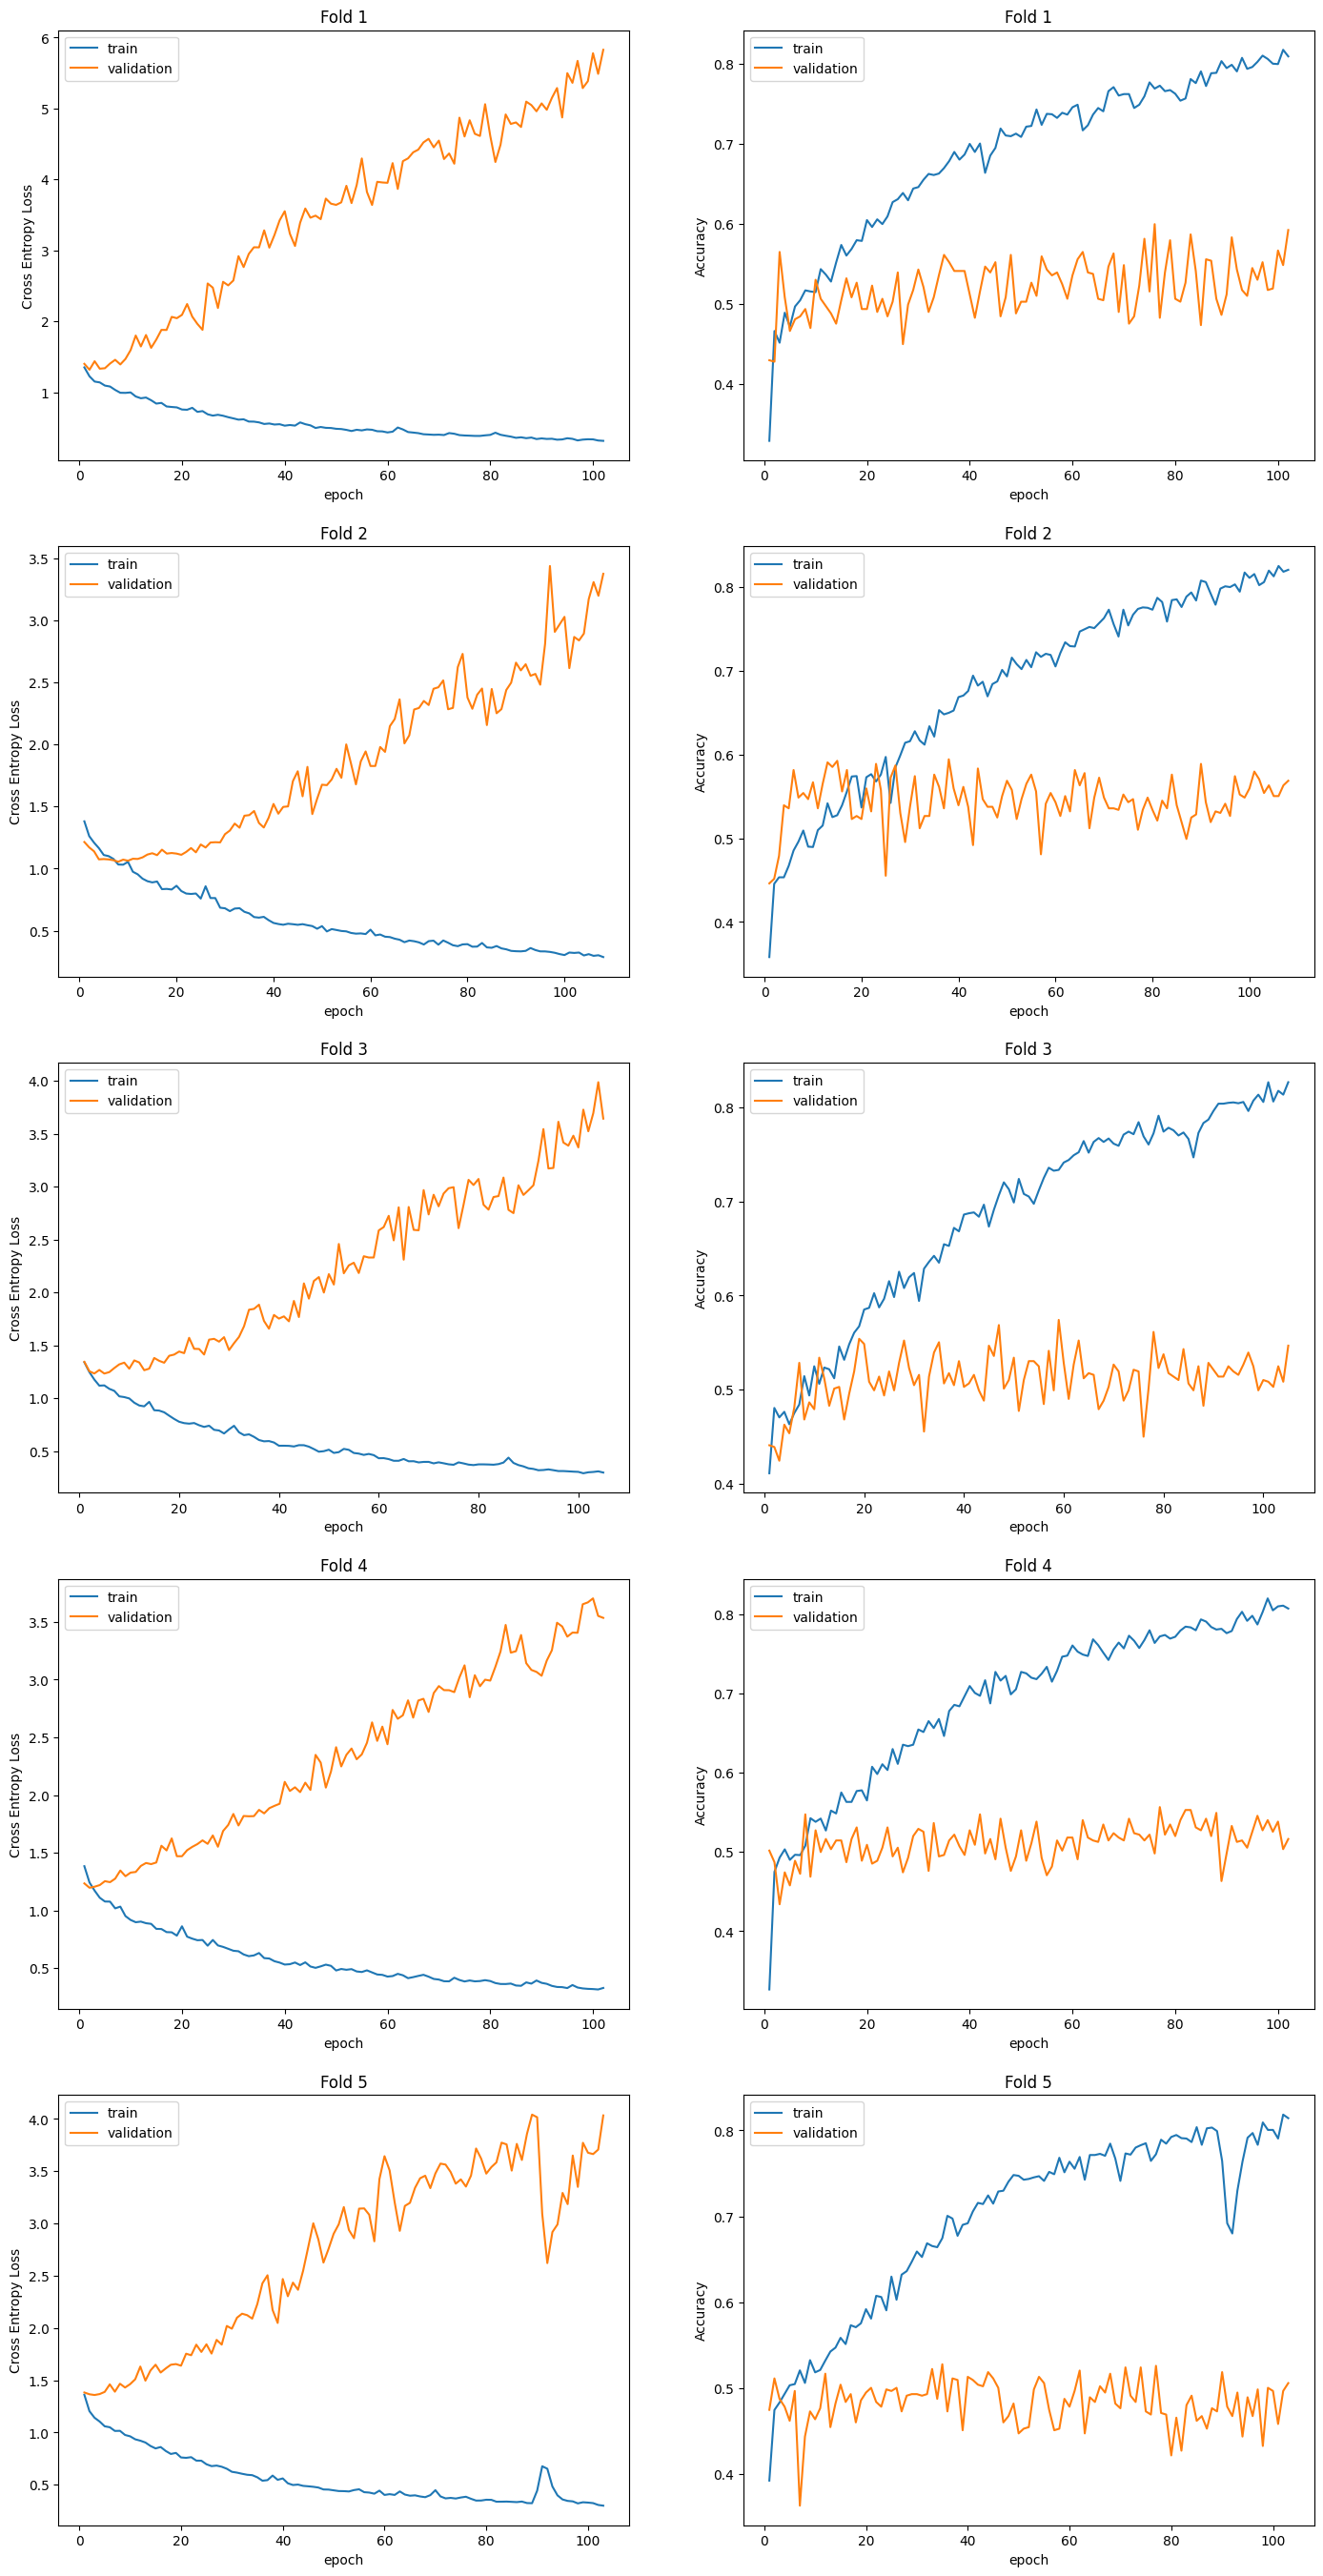

In [37]:
# plotting the train and validation set metrics across the epochs
fig, ax = plt.subplots(K, 2, figsize=(17, (6 * K) + (K - 1)))
for fold in range(K):
    _ = sns.lineplot(k_fold_results[f"fold{fold + 1}"], x="epoch", y="train_loss", c="tab:blue", legend="brief", label="train", ax=ax[fold][0])
    _ = sns.lineplot(k_fold_results[f"fold{fold + 1}"], x="epoch", y="val_loss", c="tab:orange", legend="brief", label="validation", ax=ax[fold][0])
    _ = ax[fold][0].set_ylabel("Cross Entropy Loss")
    _ = ax[fold][0].set_title(f"Fold {fold + 1}")
    _ = sns.lineplot(k_fold_results[f"fold{fold + 1}"], x="epoch", y="train_acc", c="tab:blue", legend="brief", label="train", ax=ax[fold][1])
    _ = sns.lineplot(k_fold_results[f"fold{fold + 1}"], x="epoch", y="val_acc", c="tab:orange", legend="brief", label="validation", ax=ax[fold][1])
    _ = ax[fold][1].set_ylabel("Accuracy")
    _ = ax[fold][1].set_title(f"Fold {fold + 1}")

In [38]:
train_preds = None
for fold in range(1, K + 1):
    if train_preds is None:
        train_preds = k_fold_preds[f"fold{fold}"]
    else:
        train_preds = pd.concat([train_preds, k_fold_preds[f"fold{fold}"]])

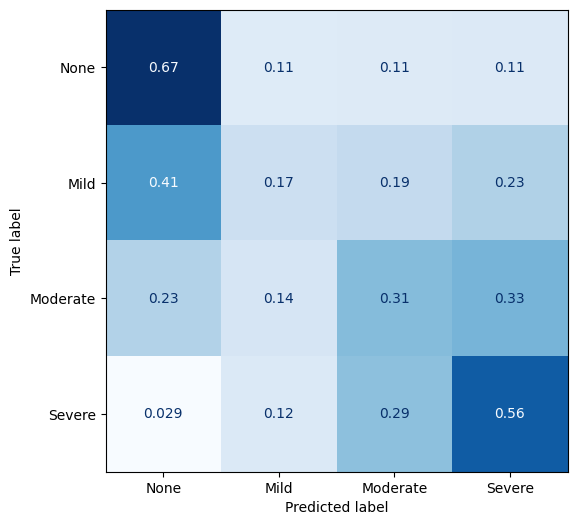

In [39]:
fig, ax = plt.subplots(figsize=(6, 6))
cm = confusion_matrix(
    train_preds["y_trues"],
    train_preds["y_preds"],
    labels=[0, 1, 2, 3],
    normalize="true",
)
disp = ConfusionMatrixDisplay(cm, display_labels=["None", "Mild", "Moderate", "Severe"])
_ = disp.plot(ax=ax, cmap="Blues", colorbar=False)

In [40]:
accuracy = accuracy_score(train_preds["y_trues"], train_preds["y_preds"])
qwk = cohen_kappa_score(train_preds["y_trues"], train_preds["y_preds"], weights="quadratic")
print(f"Unbiased Train Accuracy - {accuracy:.6f}")
print(f"Unbiased Train QWK - {qwk:.6f}")

Unbiased Train Accuracy - 0.481888
Unbiased Train QWK - 0.296683


### Test Data Inference

In [41]:
test_dataset = TimeSeriesData(test_data, test_series_data, None, False)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn
)

In [42]:
test_results = {f"fold{fold}": [] for fold in range(1, K + 1)}
for fold in range(1, K + 1):
    model = k_fold_models[f"fold{fold}"]
    model.eval()
    with torch.no_grad():
        for static_batch, time_series_batch, _ in test_dataloader:
            pred = model(static_batch, time_series_batch)
            prob = torch.softmax(pred, dim=1)
            cls = torch.argmax(prob, dim=1)[0]
            test_results[f"fold{fold}"].append(cls.item())

In [43]:
test_results = pd.DataFrame(test_results)
test_results["id"] = test_ids
test_results["sii"] = test_results.mode(axis=1, numeric_only=True)[0].astype(int)
test_results = test_results.drop(columns=[f"fold{fold}" for fold in range(1, K + 1)])
test_results

,id,sii
0,00008ff9,0
1,000fd460,0
2,00105258,1
3,00115b9f,0
4,0016bb22,1
5,001f3379,2
6,0038ba98,2
7,0068a485,3
8,0069fbed,3
9,0083e397,0


In [44]:
test_results.to_csv("submission.csv", index=False)